# Extracting polygons from shapefiles

When dealing with polygon data in a shapefile, you may want to find the relative pixel locations of the polygons to the overall raster files. This can be done using `ogr` and the `gdal` library

References: 
- https://automating-gis-processes.github.io/2016/Lesson2-geopandas-basics.html
- https://software.intel.com/en-us/blogs/2017/09/08/pre-processing-geotiff-files-and-training-deepmasksharpmask-model


In [2]:
from osgeo import gdal,ogr
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import fiona
import rasterio
import rasterio.plot

In [3]:
shp = '/efs/data/jpb/data/tiles/raw_data/polygons/Dagahaley_Structures/Dagahaley_Structures.shp'
raster = '/efs/data/jpb/data/tiles/raw_data/images/Dana_IDPs_20190606.tif'

## Initial overview

In [4]:
gdf = gpd.read_file(shp)

In [5]:
gdf.crs

{'init': 'epsg:4326'}

In [68]:
src = rasterio.open(raster)

In [69]:
src.crs

CRS({'init': 'epsg:3857'})

**Note:** CRS are different -> convert shapefile

In [6]:
gdf_new = gdf.to_crs({'init': 'epsg:3857'})

In [7]:
gdf_new.head()

,TYPE,geometry
0,Structure,"POLYGON ((4483985.803323007 20876.20940667135,..."
1,Structure,"POLYGON ((4483986.928985697 20877.51597052965,..."
2,Structure,"POLYGON ((4483980.933651878 20824.10236704085,..."
3,Structure,"POLYGON ((4483982.258131184 20819.73182922421,..."
4,Structure,"POLYGON ((4483968.629953837 20850.41832378297,..."


## Extract information

In [55]:
errors = []
g = gdf_new['geometry']
all_coords = []
for j in range(len(g)):
    coord = []
    try:
        "Handling of polygons"
        for i in g[j].boundary.coords:
            coord.append(i)
    except:
        "Handling of multipolygons"
        for i in g[j].boundary:
            for k in i.coords:
                coord.append(k)
        errors.append(j)
    all_coords.append(coord)

In [56]:
errors

[16846, 17480, 17534, 19100, 19284, 19318, 19363, 20195, 21482]

In [57]:
def world2Pixel(geoMatrix, x, y):
    """
    Uses a gdal geomatrix (.transform) to calculate
    the pixel location of a geospatial coordinate
    """
    ulX = geoMatrix[2]
    ulY = geoMatrix[5]
    xDist = geoMatrix[0]
    yDist = geoMatrix[4]
    rtnX = geoMatrix[1]
    rtnY = geoMatrix[3]
    pixel = int((x - ulX) / xDist)
    line = int((ulY - y) / xDist)
    return (pixel, line)

In [ ]:
gt = src.transform

In [116]:
pixel_coords = []
for i in all_coords:
    coords = []
    for j in i:
        coords.append(world2Pixel(gt,j[0],j[1]))
    pixel_coords.append(coords)

In [118]:
pc = np.array(pixel_coords)

In [127]:
pc.shape

(14623, 5, 2)

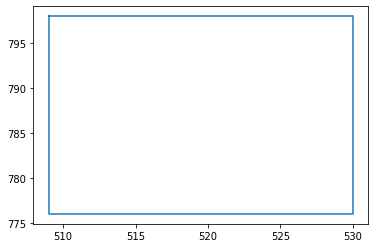

In [125]:
plt.plot(pc[0,:,0],pc[0,:,1])